Train shape: (455, 31) Test shape: (114, 31)
Linear SVM accuracy: 0.9649
RBF SVM accuracy: 0.9649

Classification report (RBF):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114

Confusion matrix (RBF):
 [[71  1]
 [ 3 39]]


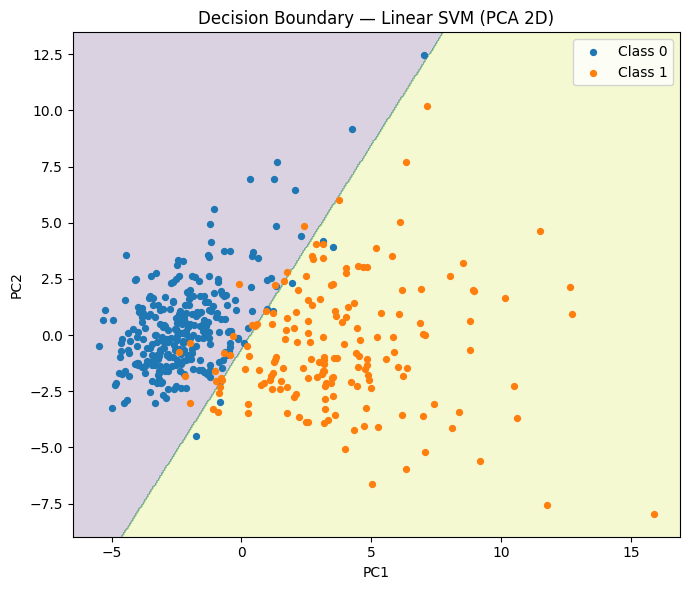

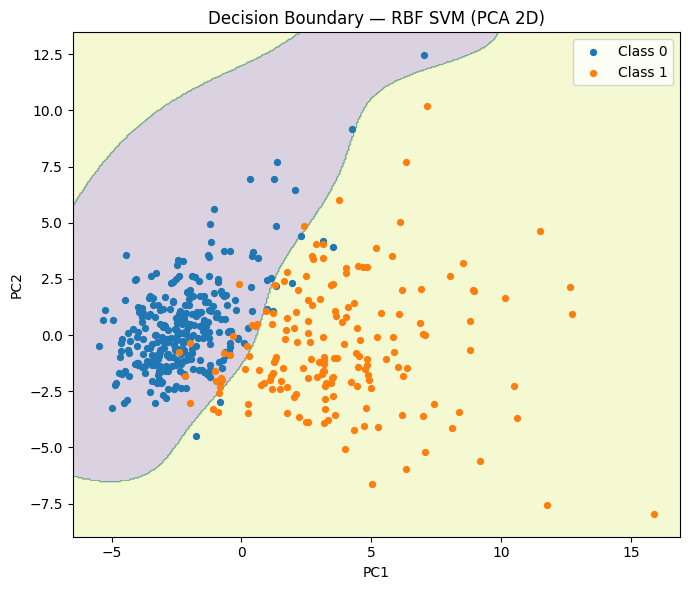

Best Linear SVM: {'svc__C': np.float64(0.1)} CV Accuracy: 0.9718987734823784
Best RBF SVM: {'svc__C': np.float64(10.0), 'svc__gamma': np.float64(0.01)} CV Accuracy: 0.9806707033069397
Test accuracy (best linear): 0.9824561403508771
Test accuracy (best RBF): 0.9824561403508771
CV Linear SVM: mean=0.9684, std=0.0162, folds=[0.96491228 0.94736842 0.95614035 0.99122807 0.98230088]
CV RBF SVM:    mean=0.9772, std=0.0163, folds=[0.99122807 0.94736842 0.97368421 0.99122807 0.98230088]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA

# STEP 1 — LOAD & PREPARE DATA (CUSTOM DATASET)

data_path = r"/content/breast-cancer.csv"

df = pd.read_csv(data_path)
target_col = "diagnosis"

X = df.drop(columns=[target_col])
y = df[target_col]

if y.dtype == 'object' or y.dtype == 'bool':
    y = y.astype('category').cat.codes  # Maps categories to integers

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

if hasattr(y, "cat") and hasattr(y.cat, "categories"):
    class_names = list(y.cat.categories)
else:
    class_names = ["Class 0", "Class 1"]

print("Train shape:", X_train_s.shape, "Test shape:", X_test_s.shape)

# STEP 2 — TRAIN SVM (LINEAR & RBF)

clf_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=1.0, random_state=42))
])
clf_linear.fit(X_train, y_train)
y_pred_lin = clf_linear.predict(X_test)
print(f"Linear SVM accuracy: {accuracy_score(y_test, y_pred_lin):.4f}")

clf_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42))
])
clf_rbf.fit(X_train, y_train)
y_pred_rbf = clf_rbf.predict(X_test)
print(f"RBF SVM accuracy: {accuracy_score(y_test, y_pred_rbf):.4f}")

print("\nClassification report (RBF):\n", classification_report(y_test, y_pred_rbf))
print("Confusion matrix (RBF):\n", confusion_matrix(y_test, y_pred_rbf))

# STEP 3 — VISUALIZE DECISION BOUNDARY (PCA 2D)

pca = PCA(n_components=2, random_state=42)
X_train_2d = pca.fit_transform(scaler.fit_transform(X_train))
X_test_2d  = pca.transform(scaler.transform(X_test))

svm2d_linear = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=1.0, random_state=42))
]).fit(X_train_2d, y_train)

svm2d_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42))
]).fit(X_train_2d, y_train)

def plot_decision_boundary(model, X, y, title):
    x_min, x_max = X[:,0].min() - 1.0, X[:,0].max() + 1.0
    y_min, y_max = X[:,1].min() - 1.0, X[:,1].max() + 1.0
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 400),
        np.linspace(y_min, y_max, 400)
    )
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X[y==0,0], X[y==0,1], s=18, label=class_names[0])
    plt.scatter(X[y==1,0], X[y==1,1], s=18, label=class_names[1])
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_decision_boundary(svm2d_linear, X_train_2d, y_train, "Decision Boundary — Linear SVM (PCA 2D)")
plot_decision_boundary(svm2d_rbf, X_train_2d, y_train, "Decision Boundary — RBF SVM (PCA 2D)")

# STEP 4 — HYPERPARAMETER TUNING

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipe_lin = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", random_state=42))
])
param_grid_lin = {"svc__C": np.logspace(-3, 3, 7)}
gs_lin = GridSearchCV(pipe_lin, param_grid_lin, cv=cv, n_jobs=-1, scoring="accuracy")
gs_lin.fit(X, y)
print("Best Linear SVM:", gs_lin.best_params_, "CV Accuracy:", gs_lin.best_score_)

pipe_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", random_state=42))
])
param_grid_rbf = {
    "svc__C": np.logspace(-3, 3, 7),
    "svc__gamma": np.logspace(-4, 1, 6)
}
gs_rbf = GridSearchCV(pipe_rbf, param_grid_rbf, cv=cv, n_jobs=-1, scoring="accuracy")
gs_rbf.fit(X, y)
print("Best RBF SVM:", gs_rbf.best_params_, "CV Accuracy:", gs_rbf.best_score_)

best_lin = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=gs_lin.best_params_["svc__C"], random_state=42))
])
best_lin.fit(X_train, y_train)
print("Test accuracy (best linear):", accuracy_score(y_test, best_lin.predict(X_test)))

best_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=gs_rbf.best_params_["svc__C"], gamma=gs_rbf.best_params_["svc__gamma"], random_state=42))
])
best_rbf.fit(X_train, y_train)
print("Test accuracy (best RBF):", accuracy_score(y_test, best_rbf.predict(X_test)))

# STEP 5 — CROSS-VALIDATION PERFORMANCE

base_lin = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=1.0, random_state=42))
])
base_rbf = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42))
])

scores_lin = cross_val_score(base_lin, X, y, cv=cv, scoring="accuracy", n_jobs=-1)
scores_rbf = cross_val_score(base_rbf, X, y, cv=cv, scoring="accuracy", n_jobs=-1)

print(f"CV Linear SVM: mean={scores_lin.mean():.4f}, std={scores_lin.std():.4f}, folds={scores_lin}")
print(f"CV RBF SVM:    mean={scores_rbf.mean():.4f}, std={scores_rbf.std():.4f}, folds={scores_rbf}")
